In [1]:
import sys
sys.path.insert(0, '../')

# sys.path.remove("/home/users/yixiuz/.local/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/lib/python3.9/site-packages")
sys.path.append("/home/groups/swl1/yixiuz/torch_fid/bin")

import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections

from config.eval.piano import get_config as get_eval_config
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = get_eval_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
test_dataset = np.load(eval_cfg.sampler.test_dataset)
condition_dim = eval_cfg.sampler.condition_dim
descramble_key = np.loadtxt(eval_cfg.pianoroll_dataset_path + '/descramble_key.txt')

def descramble(samples):
    return descramble_key[samples.flatten()].reshape(*samples.shape)

descrambled_test_dataset = descramble(test_dataset)

2024-04-11 16:42:10.960141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:42:11.076729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/cudnn/8.9.0.131/lib:/usr/lib64/nvidia:/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib:/share/software/user/open/cuda/12.2.0/lib64:/share/software/user/open/cuda/12.2.0/nvvm/lib64:/share/software/user/open/cuda/12.2.0/extras/Debugger/lib64:/share/software/user/open/cuda/12.2.0/extras/CUPTI/lib64:/share/software/user/open/python/3.9.0/lib:/share/software/u

In [2]:
# -------------- Sample the model ------------------
num_samples = 1
test_data_idx = 8
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
sampler = sampling_utils.get_sampler(eval_cfg)
samples, x_hist, x0_hist = sampler.sample(model, 1, 10, conditioner)
samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)


1000it [00:16, 59.76it/s]


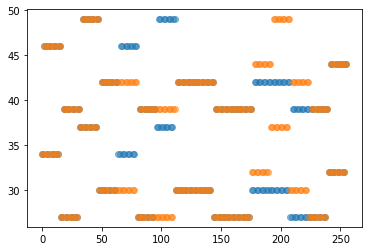

In [3]:
idx = 0
plt.scatter(np.arange(256), samples[idx, :], alpha=0.5)
plt.scatter(np.arange(256), descrambled_test_dataset[test_data_idx, :], alpha=0.5)
plt.show()